<a href="https://colab.research.google.com/github/chantelleyy/Youtube_Channel_Scraper/blob/main/Youtube_Channel_Data_Scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import argparse
from googleapiclient.discovery import build

def load_api_key():
    from google.colab import userdata
    return userdata.get('APIKey').strip()

API_KEY = load_api_key()
youtube = build('youtube', 'v3', developerKey=API_KEY)


In [ ]:
def fetch_channel_info(youtube, handle):
    """Return channel ID and uploads playlist ID."""
    search_response = youtube.search().list(
        part='snippet',
        q=handle,
        type='channel',
        maxResults=1
    ).execute()

    if not search_response['items']:
        raise ValueError(f"Channel '{handle}' not found.")
    channel_id = search_response['items'][0]['snippet']['channelId']
    print("Channel ID:", channel_id)

    channel_response = youtube.channels().list(
        part='contentDetails',
        id=channel_id
    ).execute()

    uploads_playlist_id = channel_response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
    print("Uploads Playlist ID:", uploads_playlist_id)

    return channel_id, uploads_playlist_id



In [ ]:
def fetch_videos(youtube, uploads_playlist_id):
    """Return list of videos with ID, title, and published date."""
    videos = []
    request = youtube.playlistItems().list(
        part='snippet,contentDetails',
        playlistId=uploads_playlist_id,
        maxResults=50
    )

    while request:
        response = request.execute()
        for item in response['items']:
            video_id = item['snippet']['resourceId']['videoId']
            title = item['snippet']['title']
            publish_time = item['snippet']['publishedAt']
            videos.append({
                'video_id': video_id,
                'title': title,
                'publishedAt': publish_time
            })
        request = youtube.playlistItems().list_next(request, response)

    return videos

In [ ]:
def fetch_video_stats(youtube, video_ids):
    """Return video statistics and thumbnail URLs."""
    stats = []
    for i in range(0, len(video_ids), 50):
        batch = video_ids[i:i+50]
        v_response = youtube.videos().list(
            part='statistics,snippet',
            id=','.join(batch)
        ).execute()

        for vi in v_response['items']:
            snippet = vi['snippet']
            statistics = vi['statistics']
            thumbnails = snippet.get('thumbnails', {})

            # Safely extract thumbnail
            thumbnail_url = None
            for quality in ['maxres', 'standard', 'high', 'medium', 'default']:
                if quality in thumbnails:
                    thumbnail_url = thumbnails[quality]['url']
                    break

            stats.append({
                'video_id': vi['id'],
                'title': snippet.get('title', 'N/A'),
                'views': int(statistics.get('viewCount', 0)),
                'likes': int(statistics.get('likeCount', 0)),
                'description': snippet.get('description', ''),
                'categoryId': snippet.get('categoryId', ''),
                'tags': ', '.join(snippet.get('tags', [])) if 'tags' in snippet else 'None',
                'publishedAt': snippet.get('publishedAt')
            })
    return stats

In [ ]:
handle = "astrum"
channel_id, uploads_playlist_id = fetch_channel_info(youtube, handle)

# 4. Get all video metadata
videos = fetch_videos(youtube, uploads_playlist_id)
print(f"Total videos retrieved from channel: {len(videos)}")

# 5. Get stats
video_ids = [v['video_id'] for v in videos]
stats = fetch_video_stats(youtube, video_ids)


Channel ID: UC-9b7aDP6ZN0coj9-xFnrtw
Uploads Playlist ID: UU-9b7aDP6ZN0coj9-xFnrtw
Total videos retrieved from channel: 424


In [ ]:
def display_top_videos(stats):
    """Display top 10 most viewed and liked videos."""
    top_viewed = sorted(stats, key=lambda x: x['views'], reverse=True)[:10]
    top_liked = sorted(stats, key=lambda x: x['likes'], reverse=True)[:10]

    print("\nTop 10 Most Viewed Videos:")
    for v in top_viewed:
        print({
            'video_id': v['video_id'],
            'title': v['title'],
            'views': str(v['views']),
            'likes': str(v['likes'])
        })

    print("\nTop 10 Most Liked Videos:")
    for v in top_liked:
        print({
            'video_id': v['video_id'],
            'title': v['title'],
            'views': str(v['views']),
            'likes': str(v['likes'])
        })
    return top_viewed

In [ ]:
def display_top_descriptions(top_viewed):
    """Display descriptions of the top 5 most viewed videos."""
    print("\nDescriptions for Top 5 Viewed Videos:")
    for v in top_viewed[:5]:
        print(f"\nTitle: {v['title']}")
        desc = v['description']
        if len(desc) > 500:
            desc = desc[:500] + "..."
        print("Description:")
        print(desc)

In [ ]:
def display_top_descriptions_and_tags(top_viewed):
    """Display descriptions and tags of the top 5 most viewed videos."""
    print("\nDescriptions & Tags for Top 5 Viewed Videos:")
    for v in top_viewed[:5]:
        print(f"\nTitle: {v['title']}")
        desc = v['description']
        if len(desc) > 500:
            desc = desc[:500] + "..."
        print("Description:")
        print(desc)
        print("Tags:", v['tags'])

In [ ]:
from collections import Counter

def extract_top_tags(top_viewed, top_n=10):
    """Extract and display the top N most frequent tags from top-viewed videos."""
    tag_counter = Counter()

    for video in top_viewed:
        tags = video.get('tags', [])

        # If tags is a string (e.g., comma-separated), split it
        if isinstance(tags, str):
            tags = [tag.strip() for tag in tags.split(',')]

        # Make sure it's a list
        if isinstance(tags, list):
            tag_counter.update(tags)

    top_tags = tag_counter.most_common(top_n)

    print(f"\nTop {top_n} Most Frequent Tags in Top Viewed Videos:")
    for tag, count in top_tags:
        print(f"{tag}: {count} times")

    return top_tags

In [ ]:
def main(handle='astrumextra'):
    """Main function to scrape and display YouTube channel video stats."""
    API_KEY = load_api_key()
    youtube = build('youtube', 'v3', developerKey=API_KEY)

    # Get channel info
    channel_id, uploads_playlist_id = fetch_channel_info(youtube, handle)

    # Fetch videos
    videos = fetch_videos(youtube, uploads_playlist_id)
    video_ids = [v['video_id'] for v in videos]

    # Fetch stats
    stats = fetch_video_stats(youtube, video_ids)

    # Display structured stats
    top_viewed = display_top_videos(stats)
    display_top_descriptions_and_tags(top_viewed)

    display_top_descriptions_and_tags(top_viewed)
    extract_top_tags(top_viewed)

In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Scrape YouTube channel data.")
    parser.add_argument('--handle', default='astrum', help="YouTube channel handle (e.g., astrum)")
    args, _ = parser.parse_known_args()
    main(args.handle)

Channel ID: UC-9b7aDP6ZN0coj9-xFnrtw
Uploads Playlist ID: UU-9b7aDP6ZN0coj9-xFnrtw

Top 10 Most Viewed Videos:
{'video_id': 'D5XPuS-Y0fg', 'title': 'The Final Images We Will Ever See of Pluto and Arrokoth', 'views': '17669028', 'likes': '228391'}
{'video_id': '6EbuAEagQj4', 'title': 'The Deepest We Have Ever Seen Into the Sun | SDO 4K', 'views': '9336423', 'likes': '113227'}
{'video_id': '6l4kr36TzQ4', 'title': "What did NASA's New Horizons discover around Pluto?", 'views': '9196621', 'likes': '122894'}
{'video_id': 'iogVVja1MYY', 'title': 'The Gravity Illusion', 'views': '9070146', 'likes': '173380'}
{'video_id': 'tyMbktsAScE', 'title': "NASA Cassini's Final Images of Saturn Stunned Me", 'views': '8997449', 'likes': '183846'}
{'video_id': 'mggRl80WzbE', 'title': 'What El Niño Will Do to Earth', 'views': '6991834', 'likes': '90602'}
{'video_id': 'H-hZsoyUEXs', 'title': "The Tragic Final Images of NASA's Opportunity Rover | Opportunity Episode 7", 'views': '6902904', 'likes': '89713'}
{

In [ ]:
video_ids = [v['video_id'] for v in videos]
stats = fetch_video_stats(youtube, video_ids)
top_viewed = sorted(stats, key=lambda x: x['views'], reverse=True)[:10]
from datetime import datetime

upload_times = []
for v in top_viewed:
    try:
        dt = datetime.strptime(v['publishedAt'], "%Y-%m-%dT%H:%M:%SZ")
        upload_times.append(dt.time())
        print(f"{v['title']} → Uploaded at {dt.strftime('%H:%M:%S')} UTC")
    except KeyError:
        print(f"Missing 'publishedAt' for video: {v['title']}")

The Final Images We Will Ever See of Pluto and Arrokoth → Uploaded at 21:58:35 UTC
The Deepest We Have Ever Seen Into the Sun | SDO 4K → Uploaded at 19:30:00 UTC
What did NASA's New Horizons discover around Pluto? → Uploaded at 14:03:26 UTC
The Gravity Illusion → Uploaded at 17:00:23 UTC
NASA Cassini's Final Images of Saturn Stunned Me → Uploaded at 15:06:10 UTC
What El Niño Will Do to Earth → Uploaded at 21:20:58 UTC
The Tragic Final Images of NASA's Opportunity Rover | Opportunity Episode 7 → Uploaded at 17:26:44 UTC
What Voyager Detected at the Edge of the Solar System → Uploaded at 17:30:04 UTC
Everything We Know About 'Oumuamua → Uploaded at 16:01:29 UTC
Time Does Not Exist. Let me explain with a graph. → Uploaded at 18:06:22 UTC


In [ ]:
top_viewed = sorted(stats, key=lambda x: x['views'], reverse=True)[:10]

titles_top = [v['title'] for v in top_viewed if v['title']]
descs_top = [v['description'] for v in top_viewed if v['description']]

avg_title_words_top = sum(len(t.split()) for t in titles_top) / len(titles_top)
avg_desc_words_top = sum(len(d.split()) for d in descs_top) / len(descs_top)

print(f"Avg title length: {avg_title_words_top:.2f} words")
print(f"Avg description length: {avg_desc_words_top:.2f} words")

Avg title length: 8.60 words
Avg description length: 130.10 words


In [ ]:
def fetch_comments(youtube, video_id, max_comments=200):
    """Fetch top-level comments from a video."""
    comments = []
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=100,
        textFormat="plainText"
    )

    while request and len(comments) < max_comments:
        response = request.execute()
        for item in response['items']:
            snippet = item['snippet']['topLevelComment']['snippet']
            comments.append({
                'author': snippet.get('authorDisplayName'),
                'text': snippet.get('textDisplay'),
                'likes': snippet.get('likeCount'),
                'publishedAt': snippet.get('publishedAt'),
                'totalReplyCount': item['snippet'].get('totalReplyCount', 0)
            })
        request = youtube.commentThreads().list_next(request, response)

    return comments

Average sentiment: 0.12


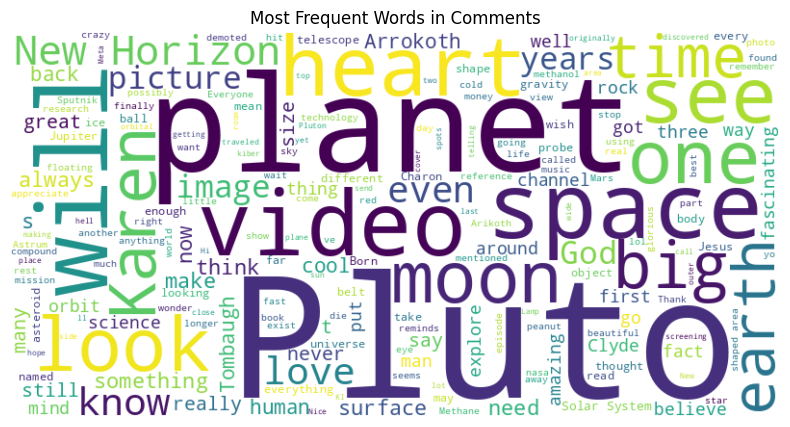

In [ ]:
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sentiment
sentiments = [TextBlob(c['text']).sentiment.polarity for c in comments]
print(f"Average sentiment: {sum(sentiments)/len(sentiments):.2f}")

# Word frequency
all_text = " ".join(c['text'] for c in comments)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Comments")
plt.show()

In [ ]:
# Most liked
top_liked = sorted(comments, key=lambda x: x['likes'], reverse=True)[:5]
print("Most Liked Comments:")
for c in top_liked:
    print(f"{c['author']} ({c['likes']} likes): {c['text'][:100]}")

# Most replied
top_replied = sorted(comments, key=lambda x: x['totalReplyCount'], reverse=True)[:5]
print("\nMost Replied Comments:")
for c in top_replied:
    print(f"{c['author']} ({c['totalReplyCount']} replies): {c['text'][:100]}")

Most Liked Comments:
@astrumspace (5061 likes): Hi Everyone! Here is the next supercut as requested. This is three New Horizons episodes merged into
@guyprovost (3 likes): That view of Alpha Centaury and the parralax blew my mind. Didn't know that. Gave me goosebumps!
@AreUmygrandson (2 likes): 10:03 it’s fascinating that the surface temperature is high enough for the methane to precipitate. A
@kriegspriest (2 likes): I didn't realise this was AI slop until it called Charon Karen.
@JordanTheMann (2 likes): Everyone is using chatGPT to write their statements now.

Most Replied Comments:
@astrumspace (156 replies): Hi Everyone! Here is the next supercut as requested. This is three New Horizons episodes merged into
@RileyTheMOTHERfan (5 replies): Conspiracy theorists: ThE yElLoW sPoTs On PlUtO aRe CiTtIeS >:(
@AntiMatter721 (5 replies): Look, I get it. Mass, gravitational forces, diameter, and other scientific terms. But Pluto is still
@BrookDesHarnais (4 replies): Millions of years = fai

In [ ]:
!pip install transformers --quiet

from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Analyze first 10 comments
for c in comments[:10]:
    result = classifier(c['text'])[0]
    print(f"{c['text'][:60]}... → {result['label']} ({result['score']:.2f})")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Hi Everyone! Here is the next supercut as requested. This is... → POSITIVE (0.99)
Pluto is a planet. They got bored and were hiding something ... → NEGATIVE (1.00)
Mars hit me because of the probe... → NEGATIVE (0.93)
I highly doubt that these are the ‘final’ pictures we’ll eve... → NEGATIVE (0.98)
Scholars agree sun's size will increase so human should begi... → POSITIVE (0.88)
Karen? You mean Char-On?... → NEGATIVE (0.99)
Goofy 🤪 is Hanging around... → POSITIVE (0.82)
What I can't help but thinking while looking at the photos, ... → POSITIVE (1.00)
Arrokoth looks like a sad baby 😂😂😂😂😂... → NEGATIVE (0.99)
Pluto is a planet.... → POSITIVE (1.00)


In [ ]:
from transformers import pipeline
from tqdm import tqdm
tqdm.pandas()

# Load model
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Run sentiment on each comment
df['sentiment'] = df['text'].progress_apply(lambda x: classifier(x[:512])[0]['label'])
df['sentiment_score'] = df['text'].progress_apply(lambda x: classifier(x[:512])[0]['score'])

Device set to use cpu
100%|██████████| 200/200 [00:14<00:00, 14.11it/s]
